In [34]:

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
import pandas as pd
from scipy import stats
import requests
import json
import random
from sklearn.metrics import accuracy_score
from scipy.stats import norm
import math

In [4]:
def encode_categorical_variables(df, categorical_vars):
    df_encoded = pd.get_dummies(df, columns=categorical_vars, drop_first=False)
    return df_encoded

In [5]:
def calculate_feature_importances(df, variables, target):
    # Subset the dataframe to include only the columns of interest
    subset = df[variables + [target]]

    # Split the data into features and target
    X = subset[variables]
    y = subset[target]

    # Define the model
    model = RandomForestRegressor(random_state=0)

    # Cross validate model to ensure robustness
    cv_scores = cross_val_score(model, X, y, cv=5)
    print(f"Cross validation scores: {cv_scores}")
    print(f"Average cross-validation score: {np.mean(cv_scores)}")

    # Train the model
    model.fit(X, y)

    # Retrieve and print the feature importances
    importances = model.feature_importances_
    for variable, importance in zip(variables, importances):
        print(f"{variable}: {importance}")


In [6]:
def perform_anova(df, cat_vars, target_var):
    anova_results = {}
    
    data=[]
    for cat in cat_vars:
        groups = [df[target_var][df[cat] == c].values for c in df[cat].unique()]
        F, p = stats.f_oneway(*groups)
        anova_results[cat] = {"F": F, "p": p}
        data.append((cat,F,p))
    anova_df = pd.DataFrame(data,columns=['Feature','F','p'])    

    return anova_results, anova_df


In [7]:
df_full = pd.read_csv('data/data_files/wandb_results/wandb_fullrun.csv')
df_4 = pd.read_csv('data/data_files/wandb_results/wandb_fullrun_4sources.csv')
df_42 = pd.read_csv('data/data_files/wandb_results/wandb_fullrun_4sources2.csv')
categorical_vars = ["articles", "filter", "labeling", "pos", "resolved"]

In [8]:
df_full4comp = pd.concat([df_4,df_42])

In [9]:

df_42encoded = encode_categorical_variables(df_42, categorical_vars)


In [10]:
encoded_cats=[ 'articles_excellent',
       'articles_protected', 'articles_random', 'articles_readworthy',
       'filter_filter.csv', 'filter_nofilter.csv', 'labeling_link',
       'labeling_namelink', 'labeling_quot', 'pos_masked', 'pos_nopos',
       'pos_pos', 'resolved_nonresolved', 'resolved_resolved']

In [11]:
df_42['Runtime'].mean()

56.361111111111114

In [12]:
df_42encoded.columns

Index(['Name', 'Agent', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime',
       'Sweep', 'fileindex', 'class_false', 'class_true', 'test_acc',
       'test_f1', 'test_prec', 'test_rec', 'transfer_acc', 'transfer_f1',
       'transfer_prec', 'transfer_rec', 'articles_excellent',
       'articles_protected', 'articles_random', 'articles_readworthy',
       'filter_filter.csv', 'filter_nofilter.csv', 'labeling_link',
       'labeling_namelink', 'labeling_quot', 'pos_masked', 'pos_nopos',
       'pos_pos', 'resolved_nonresolved', 'resolved_resolved'],
      dtype='object')

In [13]:
from sklearn.linear_model import LinearRegression

def calculate_feature_importances_and_coef(df, variables, target):
    # Subset the dataframe to include only the columns of interest
    subset = df[variables + [target]]

    # Split the data into features and target
    X = subset[variables]
    y = subset[target]

    # Define the model
    model = LinearRegression()

    # Train the model
    model.fit(X, y)

    # Retrieve and print the feature importances (coefficients in this case)
    importances = model.coef_
    for variable, importance in zip(variables, importances):
        print(f"{variable}: {importance} (influence direction: {'positive' if importance > 0 else 'negative'})")


In [14]:
encoded_cols = [
    'articles_excellent', 'articles_protected', 'articles_readworthy', 'filter_filter.csv',
    'filter_nofilter.csv', 'labeling_link', 'labeling_namelink', 'labeling_quot', 'pos_masked',
    'pos_nopos', 'pos_pos', 'resolved_nonresolved', 'resolved_resolved'
]
calculate_feature_importances(df_42encoded, encoded_cols, "transfer_acc")


Cross validation scores: [  -7.85944309  -14.42499127  -20.78746212   -6.06614377 -120.05371949]
Average cross-validation score: -33.838351948111026
articles_excellent: 0.043946178304962225
articles_protected: 0.0716121042576024
articles_readworthy: 0.0696540545360799
filter_filter.csv: 0.04098272757630572
filter_nofilter.csv: 0.04028668676745032
labeling_link: 0.045933272743440126
labeling_namelink: 0.08125332121430892
labeling_quot: 0.057118019637200756
pos_masked: 0.03085665113786886
pos_nopos: 0.026601739149253446
pos_pos: 0.419837250589566
resolved_nonresolved: 0.03634217713744516
resolved_resolved: 0.0355758169485163


In [15]:
from scipy.stats import spearmanr
def compare_rankings_spearman(rank1, rank2):
    coef, _ = spearmanr(rank1, rank2)
    return coef


from scipy.stats import kendalltau


def compare_rankings_kendall(rank1, rank2):
    tau, _ = kendalltau(rank1, rank2)
    return tau

In [50]:
test_rank = df_42[categorical_vars + ['transfer_acc', 'test_acc','fileindex']].sort_values(by='test_acc',ascending=False)
trans_rank = df_42[categorical_vars + ['transfer_acc', 'test_acc', 'fileindex']].sort_values(
    by='transfer_acc', ascending=False)
compare_rankings_kendall(list(test_rank.index), list(trans_rank.index))


0.34362859362859366

In [56]:
trans_rank.head(10)

,articles,filter,labeling,pos,resolved,transfer_acc,test_acc,fileindex
0,readworthy,nofilter.csv,namelink,pos,resolved,0.760456,0.6584,135
1,readworthy,nofilter.csv,namelink,pos,nonresolved,0.757921,0.6523,58
2,protected,nofilter.csv,link,pos,resolved,0.745247,0.6301,24
3,excellent,nofilter.csv,namelink,pos,resolved,0.736375,0.6384,123
4,protected,nofilter.csv,link,nopos,nonresolved,0.697085,0.6114,21
5,protected,nofilter.csv,namelink,pos,nonresolved,0.690748,0.6596,115
6,excellent,nofilter.csv,namelink,pos,nonresolved,0.685678,0.6583,16
7,random,nofilter.csv,link,pos,resolved,0.679341,0.6382,65
8,random,nofilter.csv,namelink,pos,nonresolved,0.675539,0.6570,74
9,readworthy,nofilter.csv,link,pos,resolved,0.667934,0.6390,0


In [38]:
def calulate_range(df,target_name,sample):
    lower_bounds=[]
    upper_bounds=[]
    confidence_level = 0.95  # for a 95% confidence interval
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    for _,row in df.iterrows():
        standard_error = math.sqrt((row[target_name] * (1 - row[target_name])) / (sample))
        lower_bounds.append(row[target_name] - z * standard_error)
        upper_bounds.append(row[target_name] + z * standard_error)
    df['lower']=lower_bounds
    df['upper']=upper_bounds
    return df


In [40]:
df_bounds.head()

,Name,Agent,State,Notes,User,Tags,Created,Runtime,Sweep,fileindex,...,test_acc,test_f1,test_prec,test_rec,transfer_acc,transfer_f1,transfer_prec,transfer_rec,lower,upper
0,frosty-sweep-136,3686l88q,finished,-,ether-meter,NaN,2023-05-21T22:00:10.000Z,43,2q8r1cww,135,...,0.6584,0.682940,0.7358,0.637167,0.760456,0.784493,0.798144,0.771300,0.730881,0.790032
1,driven-sweep-59,3686l88q,finished,-,ether-meter,NaN,2023-05-21T20:40:20.000Z,38,2q8r1cww,58,...,0.6523,0.681739,0.7448,0.628523,0.757921,0.781214,0.791183,0.771493,0.728239,0.787603
2,sandy-sweep-170,3686l88q,finished,-,ether-meter,NaN,2023-05-21T20:05:20.000Z,38,2q8r1cww,24,...,0.6301,0.641396,0.6616,0.622389,0.745247,0.735874,0.649652,0.848485,0.715054,0.775441
3,autumn-sweep-124,3686l88q,finished,-,ether-meter,NaN,2023-05-21T21:48:17.000Z,44,2q8r1cww,123,...,0.6384,0.672760,0.7434,0.614380,0.736375,0.732648,0.661253,0.821326,0.705844,0.766906
4,blooming-sweep-167,3686l88q,finished,-,ether-meter,NaN,2023-05-21T20:02:38.000Z,65,2q8r1cww,21,...,0.6114,0.582689,0.5426,0.629174,0.697085,0.741062,0.793503,0.695122,0.665242,0.728927


In [39]:
df_bounds= calulate_range(df_42,'transfer_acc',800)

In [17]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df_42['transfer_acc'], df_42['labeling'])
result = mc.tukeyhsd()
print(result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
    link namelink    0.015 0.6325 -0.0238 0.0538  False
    link     quot  -0.0309  0.147 -0.0697 0.0079  False
namelink     quot  -0.0458 0.0161 -0.0846 -0.007   True
-------------------------------------------------------


In [33]:
a=pd.DataFrame(result)

ValueError: DataFrame constructor not properly called!

In [32]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df_42['transfer_acc'], df_42['pos'])
result = mc.tukeyhsd()
print(result)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
masked  nopos   0.0198 0.2778 -0.0107 0.0502  False
masked    pos   0.1204    0.0  0.0899 0.1509   True
 nopos    pos   0.1007    0.0  0.0702 0.1311   True
---------------------------------------------------


In [18]:
from statsmodels.stats.multicomp import MultiComparison

mc = MultiComparison(df_42['transfer_acc'], df_42['labeling'])
result = mc.tukeyhsd()
print(result)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
    link namelink    0.015 0.6325 -0.0238 0.0538  False
    link     quot  -0.0309  0.147 -0.0697 0.0079  False
namelink     quot  -0.0458 0.0161 -0.0846 -0.007   True
-------------------------------------------------------


In [19]:
df_42[categorical_vars+['transfer_acc','test_acc']]

,articles,filter,labeling,pos,resolved,transfer_acc,test_acc
0,readworthy,nofilter.csv,namelink,pos,resolved,0.760456,0.6584
1,readworthy,nofilter.csv,namelink,pos,nonresolved,0.757921,0.6523
2,protected,nofilter.csv,link,pos,resolved,0.745247,0.6301
3,excellent,nofilter.csv,namelink,pos,resolved,0.736375,0.6384
4,protected,nofilter.csv,link,nopos,nonresolved,0.697085,0.6114
...,...,...,...,...,...,...,...
139,protected,filter.csv,quot,nopos,nonresolved,0.447402,0.5694
140,random,nofilter.csv,link,nopos,nonresolved,0.446134,0.5981
141,readworthy,filter.csv,quot,nopos,resolved,0.439797,0.5488
142,excellent,filter.csv,quot,nopos,resolved,0.432193,0.5388


In [22]:
anova_results, anova_df = perform_anova(df_42, categorical_vars, "transfer_acc")
display(anova_results)

{'articles': {'F': 1.2901570860863683, 'p': 0.2802434159139071},
 'filter': {'F': 0.6081401796523634, 'p': 0.43678678904611923},
 'labeling': {'F': 4.071418064369591, 'p': 0.019097583662615287},
 'pos': {'F': 50.363433696544384, 'p': 3.129970934571958e-17},
 'resolved': {'F': 0.026183255284253918, 'p': 0.8716835936169444}}

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_avg_target(df, features, target):
    # Melt dataframe to have features and their values in the same column
    melted_df = df.melt(id_vars=target, value_vars=features)

    # Calculate the average target for each feature-value pair
    avg_target = melted_df.groupby(['variable', 'value'])[target].mean().reset_index()

    # Create bar plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='value', y=target, hue='variable', data=avg_target, ci=None)

    # Set plot labels
    plt.title(f'Average {target} for each value of features')
    plt.ylabel(f'Average {target}')
    plt.xlabel('Feature Values')

    # Show the plot
    plt.show()


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_avg_target(df, features, target):
    for feature in features:
        # Calculate the average target value for each value in the feature
        avg_target = df.groupby(feature)[target].mean()

        # Create a bar plot
        plt.figure(figsize=(10, 5))
        sns.barplot(x=avg_target.index, y=avg_target.values)

        # Set plot labels
        plt.title(f'Average {target} for each value of {feature}')
        plt.ylabel(f'Average {target}')
        plt.xlabel(feature)

        # Show the plot
        plt.show()


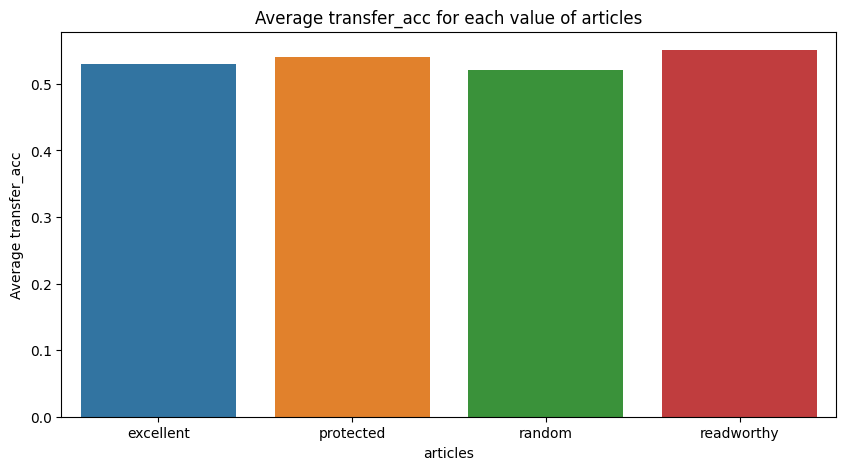

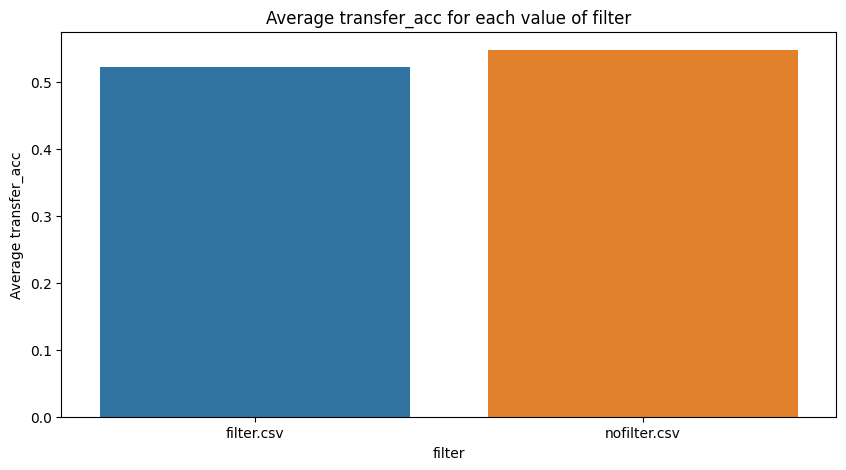

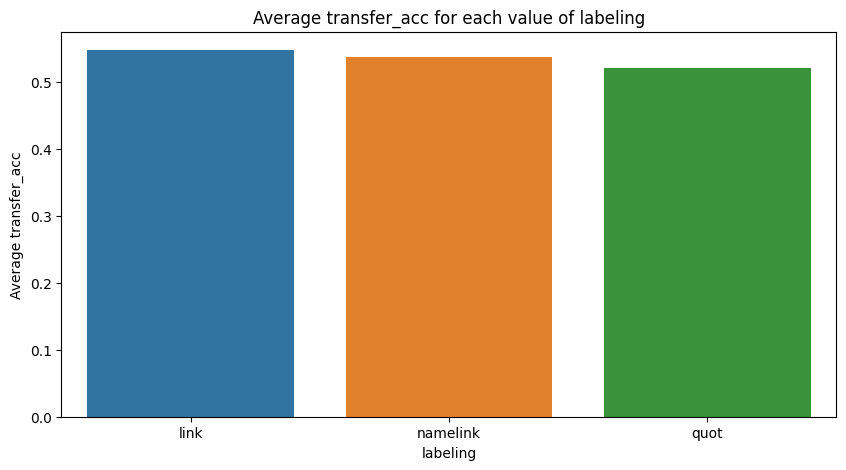

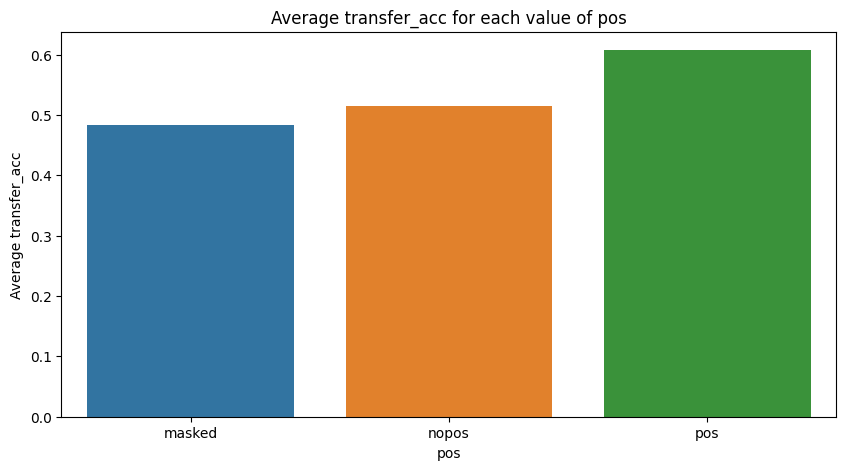

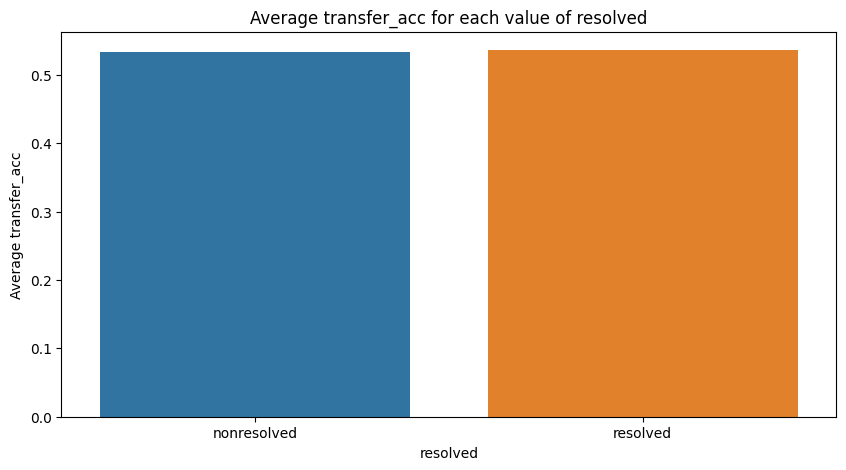

In [28]:
plot_avg_target(df_4,categorical_vars,'transfer_acc')

In [29]:
def check_anova_assumptions(df, input_vars, target_var):
    for var in input_vars:
        print(f"\nChecking assumptions for {var}:")

        # Group data by input variable categories
        groups = df.groupby(var)[target_var].apply(list)

        # Perform Shapiro-Wilk test for normality
        for i, group in enumerate(groups):
            _, p_value = stats.shapiro(group)
            if p_value > 0.05:
                print(f'Group {i} looks Gaussian (fail to reject H0)')
            else:
                print(f'Group {i} does not look Gaussian (reject H0)')
            print(p_value)

        # Perform Levene's test for equal variances
        _, p_value = stats.levene(*groups)
        if p_value > 0.05:
            print('The variances look equal (fail to reject H0)')
        else:
            print('The variances do not look equal (reject H0)')


In [30]:
check_anova_assumptions(df_full4comp, categorical_vars, 'transfer_acc')



Checking assumptions for articles:
Group 0 does not look Gaussian (reject H0)
1.5145333236432634e-06
Group 1 does not look Gaussian (reject H0)
1.2058436368533876e-05
Group 2 does not look Gaussian (reject H0)
4.982171594747342e-05
Group 3 does not look Gaussian (reject H0)
0.008563454262912273
The variances look equal (fail to reject H0)

Checking assumptions for filter:
Group 0 does not look Gaussian (reject H0)
5.128307520863018e-07
Group 1 does not look Gaussian (reject H0)
4.019598431881377e-09
The variances do not look equal (reject H0)

Checking assumptions for labeling:
Group 0 does not look Gaussian (reject H0)
0.0011542275315150619
Group 1 does not look Gaussian (reject H0)
2.657922948401392e-07
Group 2 does not look Gaussian (reject H0)
2.2043163028229174e-07
The variances do not look equal (reject H0)

Checking assumptions for pos:
Group 0 does not look Gaussian (reject H0)
1.7795479534399306e-09
Group 1 does not look Gaussian (reject H0)
5.595080438069999e-06
Group 2 does

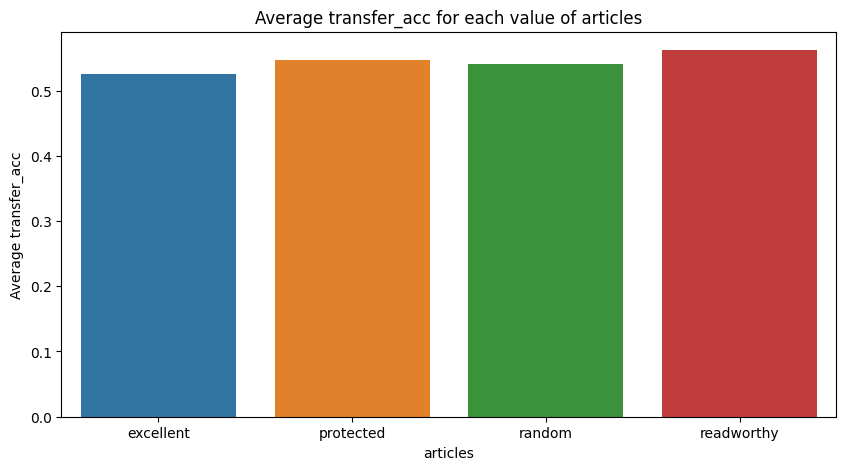

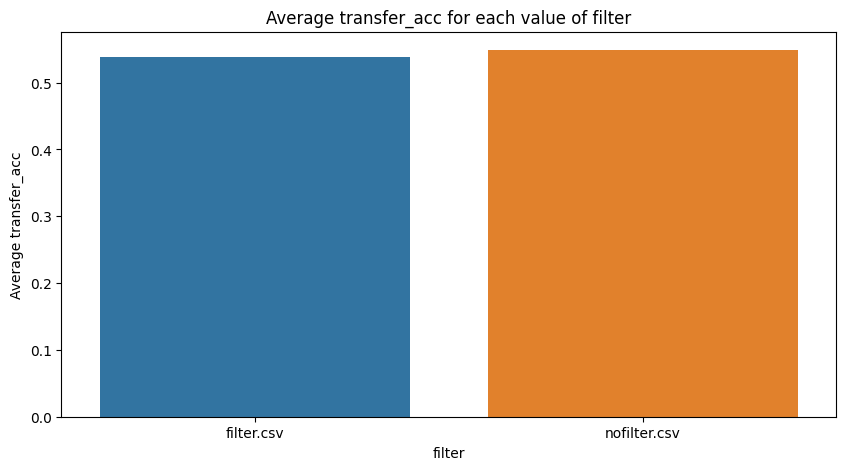

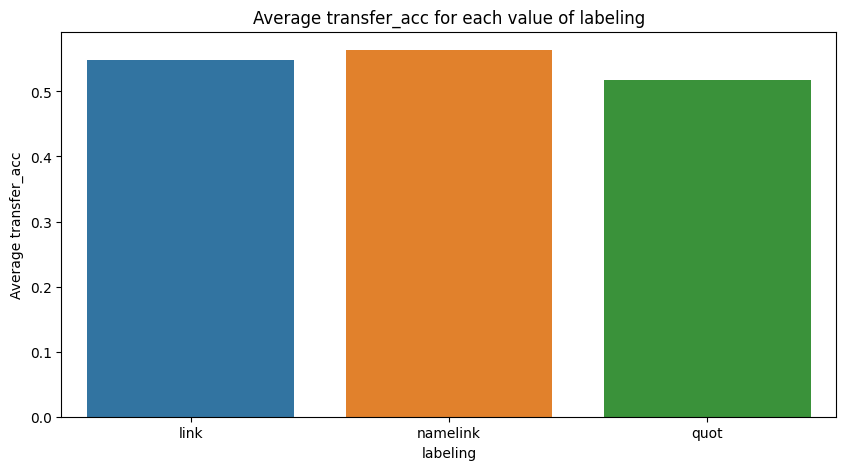

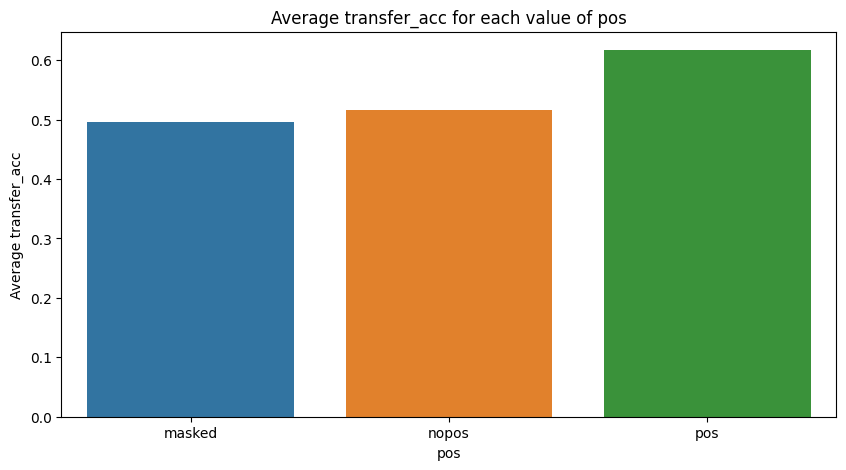

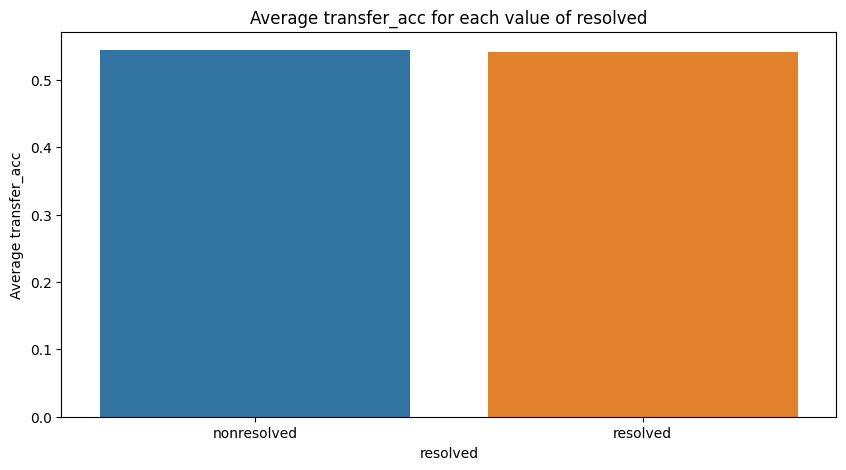

In [31]:
plot_avg_target(df_42,categorical_vars,'transfer_acc')